# Búsqueda de parametros ideales para KNN y KNN+PCA.

#### En este notebook buscamos cual es la cantidad k de vecinos ideal para el algoritmo de KNN. Luego buscamos cual es el par ideal de k vecinos y alpha componentes principales para el algoritmo de KNN+PCA.

## Compilando el módulo desde C++

#### Compilamos el modulo desde C++. En CMakeList.txt está seteado que se corra con OpenMP para paralelizar operaciones

In [76]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: no se puede crear el directorio «build»: El archivo ya existe
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Found libomp without any special flags
-- pybind11 v2.6.3 dev1
-- Found PythonInterp: /home/laureano/Documentos/met2021/grupal/metnum-1c2021-tp2/tp2/bin/python (found vers

In [77]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/home/laureano/Documentos/met2021/grupal/metnum-1c2021-tp2/notebooks
Python 3.8.5


## Explorando los datos

In [78]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
df_train = pd.read_csv("../data/train.csv")

#### Leemos el csv que tiene en cada fila una imagen de un digito y su etiqueta asociada.

In [80]:
df_train = sk.utils.shuffle(df_train, random_state = 42)
df_train = df_train[:5000]

In [81]:
cutting_point = len(df_train) - (len(df_train)//5)
df_test = df_train[cutting_point:]
df_train = df_train[:cutting_point]


#### Dividimos el set de datos en dos partes. Una parte para entrenar con cross validation y una parte para validar nuestro clasificador. Entrenamos con el 80% de los datos y validamos con el 20% restante. Si se quiere entrenar con el 100% de los datos comentar este bloque. Esto ultimo serviría para testear con kaggle.

In [82]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)
X_test = df_test[df_test.columns[1:]].values
y_test = df_test["label"].values.reshape(-1, 1)
X.shape, y.shape, X_test.shape, y_test.shape

((4000, 784), (4000, 1), (1000, 784), (1000, 1))

In [83]:
#### Pasamos los datos del set a un formato cómodo para trabajar. Chequeamos su forma.

## Validación cruzada

Implementamos una función para obtener las diferentes particiones consideradas para la validación cruzada. Arbitrariamente decidimos hacer validación cruzada de 5 folds. La cantidad de folds ideal es calculada en la notebook "K Fold".

In [84]:

def get_KFold_sets(x,y,K=5):
    X_trains = []
    Y_trains = []
    X_vals = []
    Y_vals = []
    bucket_size = len(x)//K
    for i in range(K):
        low = bucket_size*i
        high = bucket_size * (i+1)
        X_vals.append(x[low :high])
        Y_vals.append(y[low :high])
        X_train,Y_train = x[:low], y[:low]
        X_train = np.concatenate((X_train,x[high:]),axis=0)
        Y_train = np.concatenate((Y_train,y[high:]),axis=0)
        X_trains.append(X_train)
        Y_trains.append(Y_train)
    return X_trains,Y_trains,X_vals,Y_vals

In [85]:
X_trains, Y_trains, X_vals, Y_vals = get_KFold_sets(X,y)

## Métricas

#### Buscamos cuales son los parametros "ideales" para nuestros clasificadores. Notemos que si bien el accuracy(exactitud) es un buen indicador de la calidad de nuestros parametros elegidos, también existen otras métricas que sirven para evaluarlo.

#### Dentro de estas otras métricas tenemos: 
    Tiempo de ejecución
    Exactitud
    Curvas de precisión/recall
    F1-Score
    Kappa de Cohen
   

#TODO: Poner un lindo formato

#### Decidimos darle mucho imporancia al accuracy de los clasificadores, y en caso de obtener varios clasificadores con accuracy similar quedarnos con aquel que tenga un f1-score conveniente. Tomamos los f1-score de las 10 clases de los 5 clasificadores de mayor accuracy. Nos quedamos con aquel clasificador cuyo minimo f1-score de clase es el mayor entre todos los minimos.

## Busqueda de k ideal de KNN

#### Buscamos dentro del intervalo [1,101] con saltos de a 2, para darnos una idea de donde pueden ubicarse los k de mejor accuracy.

In [116]:
accsk1_a_101 = []

from tqdm import tqdm
for k in tqdm(range(1,102,2)):
    acc = 0
    for i in range(len(X_trains)): 
        clf = metnum.KNNClassifier(k)
        clf.fit(X_trains[i],Y_trains[i])
        y_pred = clf.predict(X_vals[i])
        acc += sk.metrics.accuracy_score(Y_vals[i], y_pred)
    acc = acc/len(X_trains)
    accsk1_a_101.append((acc,k))

100%|██████████| 51/51 [00:28<00:00,  1.78it/s]


In [117]:
print((accsk1_a_100))

[(0.9235, 1), (0.9285, 3), (0.9257500000000001, 5), (0.9209999999999999, 7), (0.917, 9), (0.91625, 11), (0.91175, 13), (0.9102499999999999, 15), (0.90625, 17), (0.90425, 19), (0.9012500000000001, 21), (0.9005000000000001, 23), (0.8985000000000001, 25), (0.898, 27), (0.8942500000000001, 29), (0.8920000000000001, 31), (0.88825, 33), (0.8872500000000001, 35), (0.8869999999999999, 37), (0.88275, 39), (0.8815, 41), (0.8805, 43), (0.8775000000000001, 45), (0.8752500000000001, 47), (0.8734999999999999, 49), (0.8734999999999999, 51), (0.8705, 53), (0.8710000000000001, 55), (0.8692500000000001, 57), (0.8695, 59), (0.8684999999999998, 61), (0.8657499999999999, 63), (0.8634999999999999, 65), (0.8622500000000001, 67), (0.8605, 69), (0.8584999999999999, 71), (0.857, 73), (0.8557500000000001, 75), (0.85375, 77), (0.85075, 79), (0.84925, 81), (0.84825, 83), (0.8462500000000001, 85), (0.8452500000000001, 87), (0.8442500000000001, 89), (0.84275, 91), (0.8390000000000001, 93), (0.83825, 95), (0.83425000

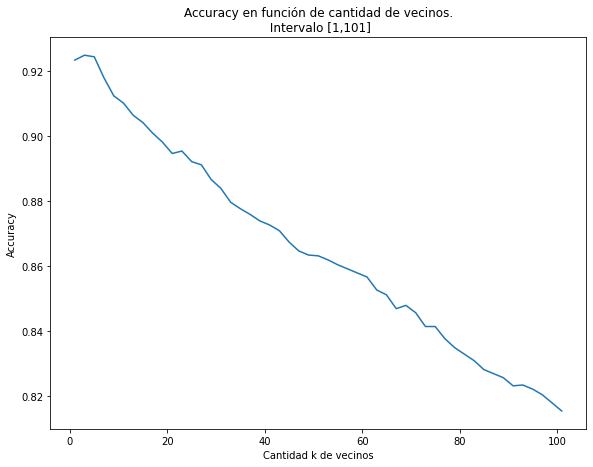

In [97]:
acc_grafico, k_grafico = zip(*accsk1_a_101)
plt.figure(figsize = (6.4 * 1.5, 4.8 *1.5))
plt.title("Accuracy en función de cantidad de vecinos.\n Intervalo [1,101]")
plt.xlabel("Cantidad k de vecinos")
plt.ylabel("Accuracy")
plt.plot(k_grafico,acc_grafico)


#### Observamos que las k que resultan en un mejor accuracy están en los números mas bajos. Buscamos dentro del intervalo [1,15] con saltos de a 1 para identificar cuales son los k que resultan en una mejor accuracy.

In [106]:
accsk1_a_15 = []

for k in tqdm(range(1,16,1)):
    acc = 0
    for i in range(len(X_trains)):
        clf = metnum.KNNClassifier(k)
        clf.fit(X_trains[i],Y_trains[i])
        y_pred = clf.predict(X_vals[i])
        acc += sk.metrics.accuracy_score(Y_vals[i], y_pred)
    acc = acc/len(X_trains)
    accsk1_a_15.append((acc,k))

100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


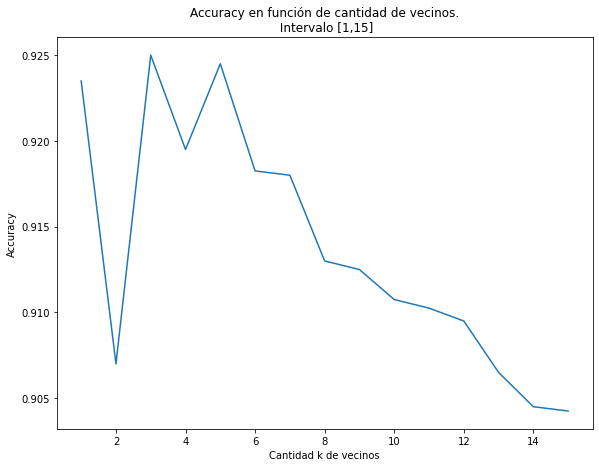

In [107]:

acc_grafico, k_grafico = zip(*accsk1_a_15)
plt.figure(figsize = (6.4 * 1.5, 4.8 *1.5))
plt.title("Accuracy en función de cantidad de vecinos.\n Intervalo [1,15]")
plt.xlabel("Cantidad k de vecinos")
plt.ylabel("Accuracy")
plt.plot(k_grafico,acc_grafico)

In [111]:
accsk1_a_15.sort(reverse = True)
mejores5k = accsk1_a_15
mejores5k = mejores5k[:5]
print(mejores5k)

[(0.925, 3), (0.9244999999999999, 5), (0.9235, 1), (0.9195, 4), (0.9182499999999999, 6)]


#### Obtenemos los 5 mejores k en accuracy. Observamos que todos tienen una accuracy mayor a 0.961 y menor a 0.964. Como estas accuracys son muy similares decidimos quedarnos con la que tenga un f1-score conveniente.

In [118]:
minimosf1 = []
for tupla in mejores5k:
    clf = metnum.KNNClassifier(tupla[1])
    clf.fit(X, y) # o sea estamos entrenando con todo el conjunto entero despues de haber validado
    #calculamos las metricas con conjuntos de test nuevos que nunca tocamos hasta ahora
   
    y_pred = clf.predict(X_test)
    minimosf1.append((np.amin(sk.metrics.f1_score(y_test,y_pred, average = None)),tupla[1]))
    

minimosf1.sort( reverse = True)
print(minimosf1)

print("Nuestra k ideal de vecinos es ", minimosf1[0][1])

[(0.8834355828220859, 3), (0.8819875776397514, 5), (0.880503144654088, 6), (0.8765432098765432, 4), (0.84472049689441, 1)]
Nuestra k ideal de vecinos es  3


In [119]:
print(np.amin(minimosf1[0][0]))

0.8834355828220859


#### Observamos que la k de mayor accuracy coincide con la k cuyo minimo f1 score es el conveniente. Luego, nuestro k ideal es 3.

## Búsqueda del par de k vecinos y alpha componentes ideal.

#### Partimos de nuestra k ideal knn para buscar el alpha ideal asociado. Luego buscamos en un rango acotado de k's y alpha's si es que existe una mejor combinación de parámetros.

In [120]:

k = 3 ### "K ideal obtenida en KNN"
accsalpha1_a_101 = []

for alpha in tqdm(range(1,102,10)):
    acc = 0
    X_trains_transformadas = []
    X_vals_transformadas = []
    for i in range(len(X_trains)):
        pca = metnum.PCA(alpha)
        %time pca.fit(X_trains[i])
        X_trains_transformadas.append(pca.transform(X_trains[i]))
        X_vals_transformadas.append(pca.transform(X_vals[i]))
        clf = metnum.KNNClassifier(k)
        clf.fit(X_trains_transformadas[i],Y_trains[i])
        y_pred = clf.predict(X_vals_transformadas[i])
        acc += sk.metrics.accuracy_score(Y_vals[i], y_pred)
    acc = acc/len(X_trains)
    accsalpha1_a_101.append((acc,alpha))


  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 1.18 s, sys: 3.94 ms, total: 1.18 s
Wall time: 120 ms
CPU times: user 779 ms, sys: 77 µs, total: 779 ms
Wall time: 68.1 ms
CPU times: user 882 ms, sys: 101 µs, total: 882 ms
Wall time: 80.5 ms


  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

CPU times: user 801 ms, sys: 68 µs, total: 801 ms
Wall time: 69.8 ms
CPU times: user 780 ms, sys: 105 µs, total: 780 ms
Wall time: 71.5 ms
CPU times: user 1.14 s, sys: 3.97 ms, total: 1.14 s
Wall time: 217 ms
CPU times: user 932 ms, sys: 59 µs, total: 932 ms
Wall time: 212 ms
CPU times: user 859 ms, sys: 96 µs, total: 859 ms
Wall time: 199 ms
CPU times: user 895 ms, sys: 71 µs, total: 895 ms
Wall time: 205 ms


 18%|█▊        | 2/11 [00:01<00:08,  1.12it/s]

CPU times: user 880 ms, sys: 4.02 ms, total: 884 ms
Wall time: 196 ms
CPU times: user 1.23 s, sys: 31.8 ms, total: 1.26 s
Wall time: 429 ms
CPU times: user 1.13 s, sys: 128 µs, total: 1.13 s
Wall time: 419 ms
CPU times: user 1.11 s, sys: 3.86 ms, total: 1.11 s
Wall time: 424 ms
CPU times: user 1.22 s, sys: 3.92 ms, total: 1.23 s
Wall time: 526 ms


 27%|██▋       | 3/11 [00:04<00:12,  1.57s/it]

CPU times: user 1.17 s, sys: 12 µs, total: 1.17 s
Wall time: 436 ms
CPU times: user 1.47 s, sys: 78 µs, total: 1.47 s
Wall time: 743 ms
CPU times: user 1.65 s, sys: 3.91 ms, total: 1.65 s
Wall time: 919 ms
CPU times: user 1.58 s, sys: 142 µs, total: 1.58 s
Wall time: 867 ms
CPU times: user 2.09 s, sys: 4.06 ms, total: 2.1 s
Wall time: 1.07 s


 36%|███▋      | 4/11 [00:08<00:19,  2.77s/it]

CPU times: user 1.52 s, sys: 0 ns, total: 1.52 s
Wall time: 845 ms
CPU times: user 2 s, sys: 0 ns, total: 2 s
Wall time: 1.2 s
CPU times: user 2.07 s, sys: 116 µs, total: 2.07 s
Wall time: 1.38 s
CPU times: user 2.26 s, sys: 11.9 ms, total: 2.27 s
Wall time: 1.24 s
CPU times: user 2.08 s, sys: 15.9 ms, total: 2.09 s
Wall time: 1.44 s


 45%|████▌     | 5/11 [00:15<00:24,  4.17s/it]

CPU times: user 1.94 s, sys: 19 µs, total: 1.94 s
Wall time: 1.23 s
CPU times: user 2.58 s, sys: 108 µs, total: 2.58 s
Wall time: 1.74 s
CPU times: user 2.86 s, sys: 15.7 ms, total: 2.87 s
Wall time: 1.76 s
CPU times: user 2.31 s, sys: 125 µs, total: 2.31 s
Wall time: 1.65 s
CPU times: user 2.45 s, sys: 0 ns, total: 2.45 s
Wall time: 1.78 s


 55%|█████▍    | 6/11 [00:24<00:29,  5.90s/it]

CPU times: user 3.85 s, sys: 3.63 ms, total: 3.86 s
Wall time: 2 s
CPU times: user 3.25 s, sys: 0 ns, total: 3.25 s
Wall time: 2.25 s
CPU times: user 2.84 s, sys: 7.8 ms, total: 2.85 s
Wall time: 2.12 s
CPU times: user 2.63 s, sys: 3.89 ms, total: 2.63 s
Wall time: 1.95 s
CPU times: user 3.12 s, sys: 0 ns, total: 3.12 s
Wall time: 2.44 s


 64%|██████▎   | 7/11 [00:35<00:30,  7.64s/it]

CPU times: user 2.92 s, sys: 0 ns, total: 2.92 s
Wall time: 2.23 s
CPU times: user 3.77 s, sys: 126 µs, total: 3.77 s
Wall time: 2.89 s
CPU times: user 3.5 s, sys: 161 µs, total: 3.5 s
Wall time: 2.79 s
CPU times: user 3.31 s, sys: 35 µs, total: 3.31 s
Wall time: 2.63 s
CPU times: user 3.78 s, sys: 128 µs, total: 3.78 s
Wall time: 3.08 s


 73%|███████▎  | 8/11 [00:50<00:29,  9.88s/it]

CPU times: user 3.66 s, sys: 4.09 ms, total: 3.67 s
Wall time: 2.99 s
CPU times: user 4.65 s, sys: 20 ms, total: 4.67 s
Wall time: 3.74 s
CPU times: user 4.1 s, sys: 7.92 ms, total: 4.1 s
Wall time: 3.37 s
CPU times: user 4.18 s, sys: 11.9 ms, total: 4.19 s
Wall time: 3.45 s
CPU times: user 4.78 s, sys: 8.1 ms, total: 4.79 s
Wall time: 4.07 s


 82%|████████▏ | 9/11 [01:08<00:25, 12.58s/it]

CPU times: user 4.28 s, sys: 8.09 ms, total: 4.28 s
Wall time: 3.6 s
CPU times: user 5.14 s, sys: 4.02 ms, total: 5.14 s
Wall time: 4.24 s
CPU times: user 4.94 s, sys: 8.04 ms, total: 4.95 s
Wall time: 4.24 s
CPU times: user 5.09 s, sys: 11.9 ms, total: 5.1 s
Wall time: 4.21 s
CPU times: user 5.13 s, sys: 12.1 ms, total: 5.14 s
Wall time: 4.44 s


 91%|█████████ | 10/11 [01:30<00:15, 15.39s/it]

CPU times: user 4.93 s, sys: 4.09 ms, total: 4.93 s
Wall time: 4.14 s
CPU times: user 5.79 s, sys: 12 ms, total: 5.8 s
Wall time: 4.86 s
CPU times: user 6.18 s, sys: 8.16 ms, total: 6.19 s
Wall time: 4.99 s
CPU times: user 5.65 s, sys: 138 µs, total: 5.65 s
Wall time: 4.95 s
CPU times: user 5.99 s, sys: 4.05 ms, total: 5.99 s
Wall time: 5.27 s


100%|██████████| 11/11 [01:55<00:00, 10.54s/it]

CPU times: user 5.66 s, sys: 4.06 ms, total: 5.67 s
Wall time: 4.96 s


In [ ]:
acc_grafico, k_grafico = zip(*accsalpha1_a_101)
plt.figure(figsize = (6.4 * 1.5, 4.8 *1.5))
plt.title("Accuracy en función de cantidad de componente principales.\n Intervalo [1,101]")
plt.xlabel("Cantidad alpha de componentes")
plt.ylabel("Accuracy")
acc_grafico, a_grafico = zip(*accs)
plt.plot(a_grafico,acc_grafico)


### Observamos un "codito". Si bien se aprecia que a mayor cantidad de alpha componentes se obtiene una mayor accuracy, podemos identificar que este crecimiento en accuracy se vuelve paulatino pasado los 20 componentes.

In [ ]:
k = 3 
accsalpha10_a_40 = []

for alpha in tqdm(range(10,41,5)):
    acc = 0
    X_trains_transformadas = []
    X_vals_transformadas = []
    for i in range(len(X_trains)):
        pca = metnum.PCA(alpha)
        pca.fit(X_trains[i])
        X_trains_transformadas.append(pca.transform(X_trains[i]))
        X_vals_transformadas.append(pca.transform(X_vals[i]))
        clf = metnum.KNNClassifier(k)
        clf.fit(X_trains_transformadas[i],Y_trains[i])
        y_pred = clf.predict(X_vals_transformadas[i])
        acc += sk.accuracy_score(Y_vals[i], y_pred)
    acc = acc/len(X_trains)
    accsalpha10_a_40.append((acc,alpha))

In [ ]:
acc_grafico, k_grafico = zip(*accsalpha10_a_40)
plt.figure(figsize = (6.4 * 1.5, 4.8 *1.5))
plt.title("Accuracy en función de cantidad de componente principales.\n Intervalo [1,40]")
plt.xlabel("Cantidad alpha de componentes")
plt.ylabel("Accuracy")
acc_grafico, a_grafico = zip(*accsalpha10_a_40)
plt.plot(a_grafico,acc_grafico)

In [ ]:
#CRITERIO DE TIEMPO DE EJECUCION

### ¿Buscamos los mejores alphas en el intervalo (25,35)?

In [ ]:
k = 3 
accs = []

for alpha in tqdm(range(25,50,5)):
    acc = 0
    X_trains_transformadas = []
    X_vals_transformadas = []
    for i in range(len(X_trains)):
        pca = metnum.PCA(alpha)
        pca.fit(X_trains[i])
        X_trains_transformadas.append(pca.transform(X_trains[i]))
        X_vals_transformadas.append(pca.transform(X_vals[i]))
        clf = metnum.KNNClassifier(k)
        clf.fit(X_trains_transformadas[i],Y_trains[i])
        y_pred = clf.predict(X_vals_transformadas[i])
        acc += sk.accuracy_score(Y_vals[i], y_pred)
    acc = acc/len(X_trains)
    accs.append((acc,alpha))

In [ ]:
acc_grafico, k_grafico = zip(*accsalpha1_a_101)
plt.figure(figsize = (6.4 * 1.5, 4.8 *1.5))
plt.title("Accuracy en función de cantidad de componente principales.\n Intervalo [1,40]")
plt.xlabel("Cantidad alpha de componentes")
plt.ylabel("Accuracy")
acc_grafico, a_grafico = zip(*accs)
plt.plot(a_grafico,acc_grafico)

#### Queremos verificar que nuestro par de k y alpha es el ideal. Para eso calculamos el accuracy para k en el intervalo [1,30] y alpha en el intervalo [15,45]

In [122]:
accspar = []
for k in tqdm(range(1,15,1)):
    for alpha in range(25,35):
        acc = 0
        X_trains_transformadas = []
        X_vals_transformadas = []
        for i in range(len(X_trains)):
            pca = metnum.PCA(alpha)
            pca.fit(X_trains[i])
            X_trains_transformadas.append(pca.transform(X_trains[i]))
            X_vals_transformadas.append(pca.transform(X_vals[i]))
            clf = metnum.KNNClassifier(k)
            clf.fit(X_trains_transformadas[i],Y_trains[i])
            y_pred = clf.predict(X_vals_transformadas[i])
            acc += sk.metrics.accuracy_score(Y_vals[i], y_pred)
        acc = acc/len(X_trains)
        accspar.append((acc,k,alpha)) 

 14%|█▍        | 2/14 [01:35<09:31, 47.62s/it]


KeyboardInterrupt: 

In [ ]:
accspar.sort(reverse = True)
mejores5pares = accspares
mejores5pares = mejores5pares[:5]
print(mejores5pares)

In [ ]:
print(accs)